In [721]:
#import modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface


In [722]:
#Carregando dados 

data = load_wine()
X = data.data
y = data.target
np.size(y,0)

178

In [723]:
#Treinamento e teste
#test_size = 0.3
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
#y_test

In [724]:
#X_train1  = pd.DataFrame(X_train)
#X_train1.to_excel("X_train.xlsx")

#X_test1  = pd.DataFrame(X_test)
#X_test1.to_excel("X_test.xlsx")

#y_train1  = pd.DataFrame(y_train)
#y_train1.to_excel("y_train.xlsx")

#y_test1  = pd.DataFrame(y_test)
#y_test1.to_excel("y_test.xlsx")

In [725]:
##Inicialização das soluções
xlsfile = pd.ExcelFile('X_train.xlsx')
X_train = xlsfile.parse('Sheet1')
X_train = X_train[X_train.columns[1:]]
X_train = X_train.to_numpy()
X_train

xlsfile1 = pd.ExcelFile('X_test.xlsx')
X_test = xlsfile1.parse('Sheet1')
X_test = X_test[X_test.columns[1:]]
X_test = X_test.to_numpy()
X_test


xlsfile2 = pd.ExcelFile('y_train.xlsx')
y_train = xlsfile2.parse('Sheet1')
y_train = y_train[y_train.columns[1:]]
#y_train = y_train.to_numpy()
y_train=y_train.values.flatten()


xlsfile3 = pd.ExcelFile('y_test.xlsx')
y_test = xlsfile3.parse('Sheet1')
y_test = y_test[y_test.columns[1:]]
#y_test = y_test.to_numpy()
y_test = y_test.values.flatten()


In [726]:
#Arquitetura da rede
n_inputs = 13 # features
n_hidden = 20 
n_classes = 3
num_samples = X_train.shape[0] 
num_samples

124

In [727]:
def logits_function(p,X_train):
    """ Calculate roll-back the weights and biases

    Inputs
    ------
    p: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    numpy.ndarray of logits for layer 2

    """
    #coeficientes
    c1 = n_hidden*n_inputs
    c2 = c1 +n_hidden
    c3 = c2 + (n_hidden*n_hidden)
    c4=  c3 + n_hidden
    c5 = c4+(n_hidden*n_classes)
    
     # First layer weights
    W1 = p[0:c1].reshape(n_inputs, n_hidden) - 1
    
    # First layer bias
    b1 = p[c1:c2].reshape(( n_hidden,))
    
    # Second layer weights
    W2 = p[c2:c3].reshape(n_hidden, n_hidden) - 1
    
    # Second layer bias
    b2 = p[c3:c4].reshape(( n_hidden,))
    W3 = p[c4:c5].reshape(n_hidden, n_classes) - 1
    b3 = p[c5:c5+n_classes].reshape((n_classes,))
    

    # Perform forward propagation
    z1 = X_train.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = np.tanh(z2)
    
    #Third linear step
    z3 = a2.dot(W3) + b3
    
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    logits = z3
   
      
    
    
    
    return logits          # Logits for Layer 2

In [774]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """
    
    
    logits = logits_function(params,X_train)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    loss = np.sum(corect_logprobs) / num_samples
    #print(loss)
    return loss

In [775]:
def f(x):
    
    
    
    
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    #print(j)
    return np.array(j)

In [776]:
##Inicialização das soluções
xlsfile4 = pd.ExcelFile('solucao_inicial.xlsx')
sol = xlsfile4.parse('Sheet1')
sol = sol[sol.columns[1:]]
initpos = sol.to_numpy()

initpos = initpos[0:30]
initpos

array([[-9.39788646e-01, -1.12497358e+00, -1.43989169e+00, ...,
         5.29348694e-01,  1.62076799e+00, -2.79366551e-01],
       [-7.48438271e-01, -3.18313805e-01, -6.68265096e-01, ...,
        -2.91582626e-01,  5.75745434e-02,  6.86654329e-01],
       [-5.59033654e-01,  1.96477263e+00, -1.91067477e+00, ...,
         1.66115088e+00,  7.93244525e-01,  9.54893197e-05],
       ...,
       [ 1.11837544e+00, -4.86618211e-01,  1.54513928e+00, ...,
         8.49938124e-01,  8.21726187e-01, -4.62638290e-01],
       [-2.70110967e-01, -1.02168077e+00, -1.77012414e+00, ...,
         1.23608316e+00, -1.61790252e+00, -2.08187838e-03],
       [ 1.89539488e+00, -1.20197217e+00,  1.02709207e+00, ...,
         3.94922700e-01,  1.67295376e-02, -1.48707824e-01]])

In [779]:
dimensions = (n_inputs * n_hidden) + (n_hidden * n_hidden)+(n_hidden*n_classes) + 2*n_hidden + n_classes
dimensions

763

In [777]:
%%time
# Initialize swarm
options = {'c1': 0.9, 'c2':0.3, 'w':0.7}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_hidden)+(n_hidden*n_classes) + 2*n_hidden + n_classes
max_bound = 2* np.ones(dimensions)
min_bound = - max_bound
bounds = (min_bound, max_bound)
# Call instance of PSO with bounds argument
hist_sim=[]
best_pos = []
best_cos = []
for i in range(1):
    optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=dimensions, options=options,bounds=bounds,init_pos=initpos)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=1)
    hist_sim.append(optimizer.cost_history)
    best_pos.append(pos)
    best_cos.append(cost)

# Plot the cost
#plot_cost_history(optimizer.cost_history)
#plt.show()
dimensions

2021-07-12 13:01:19,356 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.9, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████████|1/1, best_cost=1.48
2021-07-12 13:01:19,407 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.478971264635507, best pos: [-0.31213267 -1.64219794 -1.71755203  0.60479252  0.17645122  0.53552791
  0.91230294 -1.4346625  -1.34151349 -1.70518807  1.42586395 -1.73776541
 -0.01478354  0.95949988  0.9820905   0.33070239 -1.27610207  0.23719308
 -0.57854561 -1.39527263  1.4273405   1.53380663  1.13999668  1.19135775
 -1.59207257  0.92436317  0.20825855 -1.61818347  0.28489569 -1.06960192
 -0.63996053 -0.3695542  -0.87739664  1.31539978  1.36250751 -1.38523909
 -1.56005018 -1.62927987  0.93480126  1.8098543  -1.41807524  1.59003083
 -1.30760856 -0.17396493 -0.95688903  0.70588454  1.65697413 -1.5206155
  0.36549943 -1.78801105  1.38822378  1.55510023

763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
Wall time: 67.8 ms


In [768]:
def predict(pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """
    logits = logits_function(pos,X_test)
    
    y_pred = np.argmax(logits, axis=1)
   
    return y_pred

In [734]:
hist_sim

[[1.478971264635507,
  1.0570500304766468,
  1.0570500304766468,
  0.9356604217682737,
  0.9356604217682737,
  0.7404506869120814,
  0.7404506869120814,
  0.7404506869120814,
  0.7404506869120814,
  0.7404506869120814,
  0.692681168308375,
  0.6458408730480515,
  0.6458408730480515,
  0.6458408730480515,
  0.6458408730480515,
  0.6458408730480515,
  0.645307684300027,
  0.6416268621446687,
  0.6416268621446687,
  0.6353384760414345,
  0.6353384760414345,
  0.6353384760414345,
  0.6204756207763904,
  0.6204756207763904,
  0.6129639532446117,
  0.6081701507293811,
  0.6075726855371152,
  0.5981445313409806,
  0.5874035839357789,
  0.579343366446824,
  0.5773237542477787,
  0.5769381906076306,
  0.5735970933193167,
  0.566714489829835,
  0.5638633029613701,
  0.5619004496558705,
  0.5574497644258076,
  0.5536564161500829,
  0.5506872946858355,
  0.5487500999606403,
  0.5476062709735976,
  0.5469566487015926,
  0.5465880060191812,
  0.5459736908130285,
  0.5451811119921512,
  0.54483961022

In [735]:
numpy_array = np.array(hist_sim)
transpose = numpy_array.T
transpose_list = transpose.tolist()
convergence  = pd.DataFrame(transpose_list)
convergence

,0,1,2,3,4,5,6,7,8,9
0,1.478971,1.478971,1.478971,1.478971,1.478971,1.478971,1.478971,1.478971,1.478971,1.478971
1,1.057050,1.388407,1.129150,1.478971,1.332769,1.478971,1.409720,1.133598,1.478971,1.136223
2,1.057050,0.971227,1.020123,1.117493,1.225307,1.428749,1.398157,1.083917,0.688456,0.965068
3,0.935660,0.761938,0.939754,0.912113,0.647547,0.890446,1.027883,1.006166,0.688456,0.965068
4,0.935660,0.761938,0.909424,0.847188,0.647547,0.890446,0.861390,0.735526,0.688456,0.820643
...,...,...,...,...,...,...,...,...,...,...
495,0.529521,0.361290,0.599293,0.398939,0.417442,0.572207,0.503657,0.466357,0.515995,0.660495
496,0.529521,0.361290,0.599293,0.398939,0.417442,0.572207,0.503657,0.466357,0.515995,0.660495
497,0.529521,0.361290,0.599293,0.398939,0.417231,0.572207,0.503646,0.466357,0.515995,0.660495
498,0.529521,0.361290,0.599293,0.398939,0.417046,0.572207,0.503592,0.466357,0.515995,0.660456


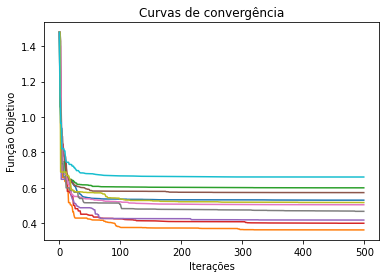

In [736]:
best = []
for i, column in enumerate(convergence.iloc[:, :]):
   ax = convergence[column].plot.line(x='pig', y='horse',title='Curvas de convergência')
   ax.set_xlabel("Iterações")
   ax.set_ylabel("Função Objetivo")
   #melhores resultados de cada simulação
   best.append(min(convergence[column]))

In [737]:
best

[0.5295207012167107,
 0.3612895421993914,
 0.5992929902387799,
 0.3989389527099922,
 0.4170461217679708,
 0.5722065344905268,
 0.5035717890969117,
 0.46635721634225086,
 0.5159951279900165,
 0.6603935498594712]

In [749]:
min_ind = np.argmin(best)
min_ind
best[min_ind]

0.3612895421993914

In [739]:
best_sol =  pd.DataFrame(best)
best_sol

,0
0,0.529521
1,0.361290
2,0.599293
3,0.398939
4,0.417046
5,0.572207
6,0.503572
7,0.466357
8,0.515995
9,0.660394


In [748]:
co = pd.DataFrame(best_cos)
best_cos[min_ind]

0.3612895421993914

In [741]:
min_ind = np.argmin(best_cos)
min_ind

1

In [742]:
len(best_pos[min_ind])

763

In [743]:
(predict(best_pos[min_ind]) == y_test).mean()

0.8703703703703703

In [744]:
best_PSO  = pd.DataFrame(best,columns =['BestPSO'])
best_PSO
best_PSO.to_excel("best_PSO.xlsx")

In [745]:
best_PSO_POS  = pd.DataFrame(best_pos)
best_PSO_POS
best_PSO_POS.to_excel("best_PSO_POS.xlsx")